## 数据准备

### 代码包引入

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
from torch import optim
import random
from tqdm import *
import matplotlib.pyplot as plt

### 数据集生成

In [2]:
# 数据集生成
soundmark = ['ei',  'bi:',  'si:',  'di:',  'i:',  'ef',  'dʒi:',  'eit∫',  'ai', 'dʒei', 'kei', 'el', 'em', 'en', 'əu', 'pi:', 'kju:',
        'ɑ:', 'es', 'ti:', 'ju:', 'vi:', 'd∧blju:', 'eks', 'wai', 'zi:']

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
         'r','s','t','u','v','w','x','y','z']

t = 1000 #总条数
r = 0.9   #扰动项
seq_len = 6
src_tokens, tgt_tokens = [],[] #原始序列、目标序列列表

for i in range(t):
    src, tgt = [],[]
    for j in range(seq_len):
        ind = random.randint(0,25)
        src.append(soundmark[ind])
        if random.random() < r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0,25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)
src_tokens[:2], tgt_tokens[:2]

([['kju:', 'kei', 'em', 'i:', 'vi:', 'pi:'],
  ['bi:', 'kju:', 'eit∫', 'eks', 'ef', 'di:']],
 [['q', 'k', 'm', 'e', 'v', 'p'], ['b', 'q', 'h', 'x', 'f', 'd']])

In [3]:
from collections import Counter  # 计数类

flatten = lambda l: [item for sublist in l for item in sublist]  # 展平数组
# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 4
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        })
        # 构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}

    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 3)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]

    def __len__(self):
        return len(self.index2token)

### 数据集构造

In [4]:
from torch.utils.data import DataLoader, TensorDataset

#实例化source和target词表
src_vocab, tgt_vocab = Vocab(src_tokens), Vocab(tgt_tokens)
src_vocab_size = len(src_vocab)  # 源语言词表大小
tgt_vocab_size = len(tgt_vocab)  # 目标语言词表大小

#增加开始标识<bos>和结尾标识<eos>
encoder_input = torch.tensor([src_vocab[line + ['<pad>']] for line in src_tokens])
decoder_input = torch.tensor([tgt_vocab[['<bos>'] + line] for line in tgt_tokens])
decoder_output = torch.tensor([tgt_vocab[line + ['<eos>']] for line in tgt_tokens])

# 训练集和测试集比例8比2，batch_size = 16
train_size = int(len(encoder_input) * 0.8)
test_size = len(encoder_input) - train_size
batch_size = 16

# 自定义数据集函数
class MyDataSet(Data.Dataset):
    def __init__(self, enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs

    def __len__(self):
        return self.enc_inputs.shape[0]

    def __getitem__(self, idx):
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

train_loader = DataLoader(MyDataSet(encoder_input[:train_size], decoder_input[:train_size], decoder_output[:train_size]), batch_size=batch_size)
test_loader = DataLoader(MyDataSet(encoder_input[-test_size:], decoder_input[-test_size:], decoder_output[-test_size:]), batch_size=1)

## 模型构建

### 位置编码

In [5]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # 偶数位用正弦函数
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # 奇数位用余弦函数
    return torch.FloatTensor(sinusoid_table)

In [6]:
print(get_sinusoid_encoding_table(30, 512))

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
          1.0366e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
          2.0733e-04,  1.0000e+00],
        ...,
        [ 9.5638e-01, -2.9214e-01,  7.9142e-01,  ...,  1.0000e+00,
          2.7989e-03,  1.0000e+00],
        [ 2.7091e-01, -9.6261e-01,  9.5325e-01,  ...,  1.0000e+00,
          2.9026e-03,  1.0000e+00],
        [-6.6363e-01, -7.4806e-01,  2.9471e-01,  ...,  1.0000e+00,
          3.0062e-03,  1.0000e+00]])


### 掩码操作

In [7]:
# mask掉没有意义的占位符
def get_attn_pad_mask(seq_q, seq_k):                       # seq_q: [batch_size, seq_len] ,seq_k: [batch_size, seq_len]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)          # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1, len_k]
    return pad_attn_mask.expand(batch_size, len_q, len_k)

# mask掉未来信息
def get_attn_subsequence_mask(seq):                               # seq: [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)          # 生成上三角矩阵,[batch_size, tgt_len, tgt_len]
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  #  [batch_size, tgt_len, tgt_len]
    return subsequence_mask 

### 注意力计算函数

In [8]:
# 缩放点积注意力计算
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

#多头注意力计算
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2) # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2) # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2) # V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]
        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model)(output + residual), attn

### 构建前馈网络

In [9]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False))
        
    def forward(self, inputs):                             # inputs: [batch_size, seq_len, d_model]
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model)(output + residual)   # 残差 + LayerNorm

### 编码器模块

In [10]:
# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()  # 多头注意力
        self.pos_ffn = PoswiseFeedForwardNet()  # 前馈网络
    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

# 编码器模块
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_vocab_size, d_model), freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        word_emb = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        pos_emb = self.pos_emb(enc_inputs) # [batch_size, src_len, d_model]
        enc_outputs = word_emb + pos_emb
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

### 解码器模块

In [11]:
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()
    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # dec_outputs: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

# 解码器模块
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_vocab_size, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
        word_emb = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        pos_emb = self.pos_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        dec_outputs = word_emb + pos_emb
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs) # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequent_mask = get_attn_subsequence_mask(dec_inputs) # [batch_size, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0) # [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # [batc_size, tgt_len, src_len]
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len,src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

### Transformer模型

In [12]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

## 模型训练

In [13]:
d_model = 512   # 字 Embedding 的维度
d_ff = 2048     # 前向传播隐藏层维度
d_k = d_v = 64  # K(=Q), V的维度 
n_layers = 6    # 有多少个encoder和decoder
n_heads = 8     # Multi-Head Attention设置为8
num_epochs = 50 # 训练50轮
# 记录损失变化
loss_history = []

model = Transformer()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for enc_inputs, dec_inputs, dec_outputs in train_loader:
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        dec_outputs: [batch_size, tgt_len]
        '''
        # enc_inputs, dec_inputs, dec_outputs = enc_inputs.to(device), dec_inputs.to(device), dec_outputs.to(device)
        # outputs: [batch_size * tgt_len, tgt_vocab_size]
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, dec_outputs.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(train_loader)
    loss_history.append(avg_loss)
    print('Epoch:', '%d' % (epoch + 1), 'loss =', '{:.6f}'.format(avg_loss))

  2%|▏         | 1/50 [00:21<17:16, 21.15s/it]

Epoch: 1 loss = 2.633762


  4%|▍         | 2/50 [00:42<17:06, 21.39s/it]

Epoch: 2 loss = 2.063002


  6%|▌         | 3/50 [01:04<16:48, 21.47s/it]

Epoch: 3 loss = 1.866944


  8%|▊         | 4/50 [01:25<16:16, 21.23s/it]

Epoch: 4 loss = 1.802783


 10%|█         | 5/50 [01:45<15:49, 21.10s/it]

Epoch: 5 loss = 1.643217


 12%|█▏        | 6/50 [02:07<15:27, 21.07s/it]

Epoch: 6 loss = 1.803471


 14%|█▍        | 7/50 [02:27<15:04, 21.02s/it]

Epoch: 7 loss = 1.518794


 16%|█▌        | 8/50 [02:48<14:41, 20.99s/it]

Epoch: 8 loss = 1.632840


 18%|█▊        | 9/50 [03:10<14:23, 21.06s/it]

Epoch: 9 loss = 1.446730


 20%|██        | 10/50 [03:31<14:02, 21.06s/it]

Epoch: 10 loss = 1.340348


 22%|██▏       | 11/50 [03:52<13:40, 21.04s/it]

Epoch: 11 loss = 1.366917


 24%|██▍       | 12/50 [04:13<13:20, 21.06s/it]

Epoch: 12 loss = 1.499715


 26%|██▌       | 13/50 [04:34<13:01, 21.12s/it]

Epoch: 13 loss = 1.371446


 28%|██▊       | 14/50 [04:55<12:41, 21.14s/it]

Epoch: 14 loss = 1.380498


 30%|███       | 15/50 [05:16<12:19, 21.14s/it]

Epoch: 15 loss = 1.298183


 32%|███▏      | 16/50 [05:37<11:53, 20.99s/it]

Epoch: 16 loss = 1.107512


 34%|███▍      | 17/50 [05:57<11:27, 20.85s/it]

Epoch: 17 loss = 1.015355


 36%|███▌      | 18/50 [06:18<11:04, 20.76s/it]

Epoch: 18 loss = 0.891573


 38%|███▊      | 19/50 [06:39<10:41, 20.69s/it]

Epoch: 19 loss = 1.035157


 40%|████      | 20/50 [06:59<10:19, 20.64s/it]

Epoch: 20 loss = 1.059943


 42%|████▏     | 21/50 [07:20<09:58, 20.64s/it]

Epoch: 21 loss = 0.995347


 44%|████▍     | 22/50 [07:40<09:38, 20.65s/it]

Epoch: 22 loss = 0.828730


 46%|████▌     | 23/50 [08:01<09:18, 20.68s/it]

Epoch: 23 loss = 0.717403


 48%|████▊     | 24/50 [08:22<08:59, 20.77s/it]

Epoch: 24 loss = 0.768870


 50%|█████     | 25/50 [08:43<08:39, 20.80s/it]

Epoch: 25 loss = 0.713927


 52%|█████▏    | 26/50 [09:04<08:18, 20.75s/it]

Epoch: 26 loss = 0.797918


 54%|█████▍    | 27/50 [09:24<07:57, 20.74s/it]

Epoch: 27 loss = 0.680246


 56%|█████▌    | 28/50 [09:45<07:36, 20.76s/it]

Epoch: 28 loss = 0.611770


 58%|█████▊    | 29/50 [10:06<07:16, 20.77s/it]

Epoch: 29 loss = 0.810355


 60%|██████    | 30/50 [10:27<06:57, 20.86s/it]

Epoch: 30 loss = 0.537487


 62%|██████▏   | 31/50 [10:48<06:37, 20.93s/it]

Epoch: 31 loss = 0.484650


 64%|██████▍   | 32/50 [11:09<06:15, 20.86s/it]

Epoch: 32 loss = 0.447033


 66%|██████▌   | 33/50 [11:30<05:54, 20.83s/it]

Epoch: 33 loss = 0.399072


 68%|██████▊   | 34/50 [11:51<05:34, 20.90s/it]

Epoch: 34 loss = 0.379649


 70%|███████   | 35/50 [12:12<05:13, 20.92s/it]

Epoch: 35 loss = 0.270823


 72%|███████▏  | 36/50 [12:32<04:52, 20.91s/it]

Epoch: 36 loss = 0.337878


 74%|███████▍  | 37/50 [12:53<04:30, 20.81s/it]

Epoch: 37 loss = 0.235440


 76%|███████▌  | 38/50 [13:14<04:09, 20.77s/it]

Epoch: 38 loss = 0.337393


 78%|███████▊  | 39/50 [13:35<03:49, 20.85s/it]

Epoch: 39 loss = 0.260191


 80%|████████  | 40/50 [13:56<03:28, 20.89s/it]

Epoch: 40 loss = 0.210084


 82%|████████▏ | 41/50 [14:17<03:09, 21.03s/it]

Epoch: 41 loss = 0.168616


 84%|████████▍ | 42/50 [14:38<02:47, 20.97s/it]

Epoch: 42 loss = 0.213607


 86%|████████▌ | 43/50 [14:58<02:25, 20.82s/it]

Epoch: 43 loss = 0.110551


 88%|████████▊ | 44/50 [15:19<02:04, 20.74s/it]

Epoch: 44 loss = 0.183562


 90%|█████████ | 45/50 [15:39<01:43, 20.62s/it]

Epoch: 45 loss = 0.095172


 92%|█████████▏| 46/50 [16:00<01:22, 20.57s/it]

Epoch: 46 loss = 0.132387


 94%|█████████▍| 47/50 [16:20<01:01, 20.52s/it]

Epoch: 47 loss = 0.163805


 96%|█████████▌| 48/50 [16:41<00:40, 20.49s/it]

Epoch: 48 loss = 0.152195


 98%|█████████▊| 49/50 [17:01<00:20, 20.49s/it]

Epoch: 49 loss = 0.086681


100%|██████████| 50/50 [17:22<00:00, 20.84s/it]

Epoch: 50 loss = 0.085496


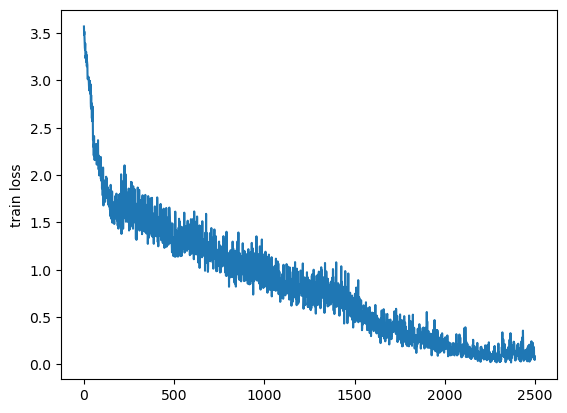

In [14]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

## 模型预测

In [15]:
model.eval()
translation_results = []

correct = 0
error = 0

for enc_inputs, dec_inputs, dec_outputs in test_loader:
    '''
    enc_inputs: [batch_size, src_len]
    dec_inputs: [batch_size, tgt_len]
    dec_outputs: [batch_size, tgt_len]
    '''
    # enc_inputs, dec_inputs, dec_outputs = enc_inputs.to(device), dec_inputs.to(device), dec_outputs.to(device)
    # outputs: [batch_size * tgt_len, tgt_vocab_size]
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    # pred形状为 (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
    # dec_outputs, dec_self_attns, dec_enc_attns = model.decoder(dec_inputs, enc_inputs, enc_output)
    
    outputs = outputs.squeeze()
    
    pred_seq = []
    for output in outputs:
        next_token_index = output.argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)
    
    pred_seq = tgt_vocab[pred_seq]
    tgt_seq = dec_outputs.squeeze().tolist()
    
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
    translation_results.append((' '.join(tgt_seq), ' '.join(pred_seq)))
    
    for i in range(len(tgt_seq)):
        if i >= len(pred_seq) or pred_seq[i] != tgt_seq[i]:
            error += 1
        else:
            correct += 1
    
print(correct/(correct+error))

0.3333333333333333


In [16]:
translation_results

[('h x n y e k', 'h y y y k'),
 ('y l z k i t', 't i t j i t y'),
 ('t s x e e v', 's s v e e v'),
 ('e g a m t h', 'f i h h h'),
 ('d b v t l r', 'e r l l r r'),
 ('d b e p m m', 'b m e m m'),
 ('e j r d f w', 'g r w w g'),
 ('p n p v w j', 'v n j v w j'),
 ('m q c v g w', 'n g g v w w'),
 ('q b j e e y', 'q y y e y y'),
 ('i x j g h z', 'g g g g h g'),
 ('m z d t r f', 'z d d f r'),
 ('o y g a c g', 'a a g g c g'),
 ('m c w z c s', 's s s s c'),
 ('h b f r z g', 'z z r g g g'),
 ('h c i o l m', 'c c o c m m'),
 ('r z e e u t', 'u e e t t t r'),
 ('g d h d q y', 'y d y y y'),
 ('r l m s u r', 'f l u s r r r'),
 ('a v q s k x', 's s s s x'),
 ('m c g a e u', 'g g a a u u'),
 ('k y y o b u', 'k o o o b u'),
 ('r n n i o s', 'o n o o s s s'),
 ('x x k y n u', 'h n n n n u'),
 ('l v q a p i', 'q i a a p i v'),
 ('v r m h w s', 'h r h h s s'),
 ('x m i o z t', 'i i i q q m'),
 ('o c y y e j', 'y y y e e j'),
 ('k w j w a d', 'w w j n n n'),
 ('m u c l x u', 'l u x l u'),
 ('y u p g r k', '